In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "worldbank_data_exploration"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [2]:
# %matplotlib widget # uncomment for interactive plots (smaller figsize and textsize advised)

import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Dataset

In [3]:
from data_sources.load_dataset import load_time_series

time_series_dict, countries, years = load_time_series()

time_series_dict.keys()

dict_keys(['Access to electricity (% of population)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Exports of goods and services (% of GDP)', 'Fertility rate, total (births per woman)', 'Forest area (% of land area)', 'GDP growth (annual %)', 'Inflation, consumer prices (annual %)', 'Life expectancy at birth, total (years)', 'Merchandise trade (% of GDP)', 'Military expenditure (% of GDP)', 'Mortality rate, under-5 (per 1,000 live births)', 'Population growth (annual %)', 'Population in the largest city (% of urban population)', 'Total natural resources rents (% of GDP)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'])

# Utils

In [4]:
def plot_normal(X, y, legend=False):
    plt.figure(figsize=(8, 8))
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], label=y[i])

    if legend:
        plt.legend()
    plt.show()


def plot_with_names(
    X,
    y,
    specific_list=[
        [
            "Poland",
            "Germany",
            "Czech Republic",
            "Slovak Republic",
            "France",
            "United Kingdom",
        ],
        ["United States", "China", "Singapore"],
        ["Kenya", "Madagascar", "Nigeria"],
        ["Ukraine", "Belarus"],
        ["Latvia", "Estonia", "Lithuania"]
    ],
    title=None,
    figsize=(16, 16),
    # figsize=(8, 8),
    textsize=7.5
    # textsize=6,
):
    plt.figure(figsize=figsize)

    mask = np.in1d(y, np.array(specific_list).flatten())
    plt.scatter(X[np.logical_not(mask)][:, 0], X[np.logical_not(mask)][:, 1])
    for specific in specific_list:
        mask = np.in1d(y, specific)
        plt.scatter(X[mask][:, 0], X[mask][:, 1])

    for i in range(X.shape[0]):
        plt.annotate(y[i], [X[i, 0], X[i, 1]], size=textsize)

    if title is not None:
        plt.title(title)
    plt.show()
    
def extract_from_all(extractor):
    if extractor is None:
        return np.hstack(list(time_series_dict.values()))
    else:
        Y_all = []
        for feature, X in time_series_dict.items():
            Y_feature = extractor.extract_features(X)
            Y_all.append(Y_feature)

        return np.hstack(Y_all)

# Single time series type

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding, SpectralEmbedding
from umap import UMAP

from feature_extraction import AutoencoderExtractor

FEATURE = "Access to electricity (% of population)"
INPUT_LEN = 21

ALG = TSNE
ALG_ARGS = {'n_components': 2, 'perplexity': 20, 'n_iter': 4000}

EXTRACTORS = [
    None,
    AutoencoderExtractor(n_bottleneck=2, feature=FEATURE, root=pwd, input_len=INPUT_LEN),
    AutoencoderExtractor(n_bottleneck=4, feature=FEATURE, root=pwd, input_len=INPUT_LEN),
    AutoencoderExtractor(n_bottleneck=8, feature=FEATURE, root=pwd, input_len=INPUT_LEN)
]

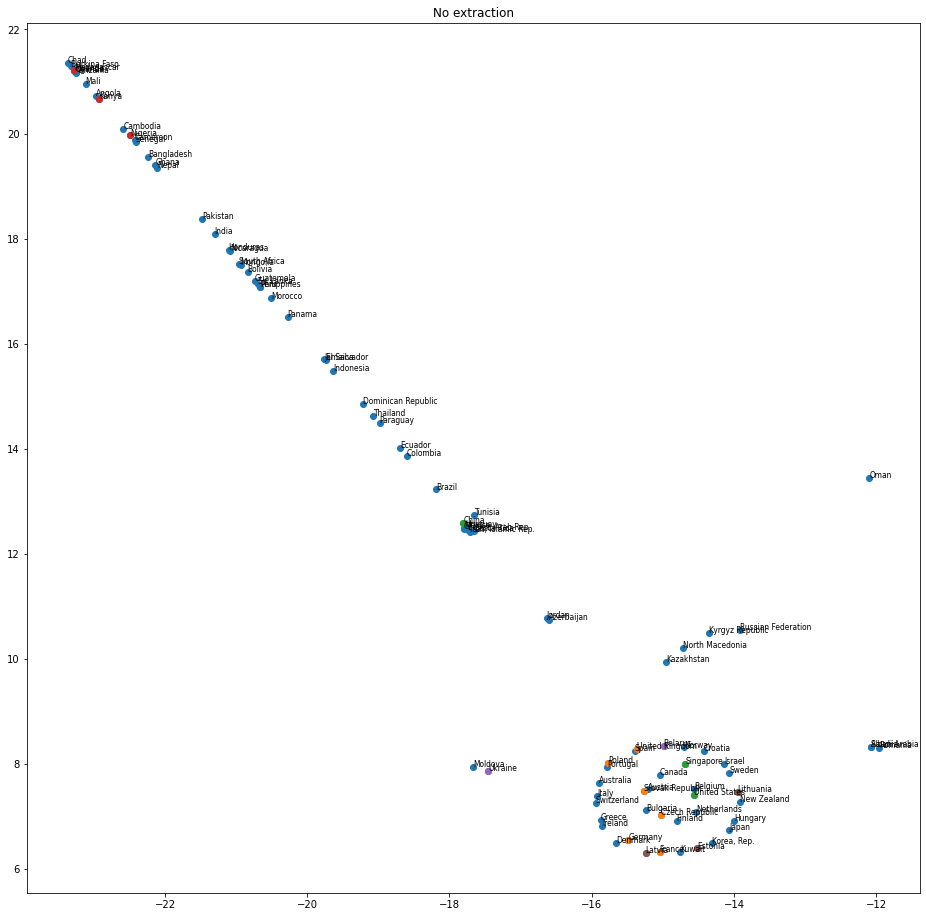

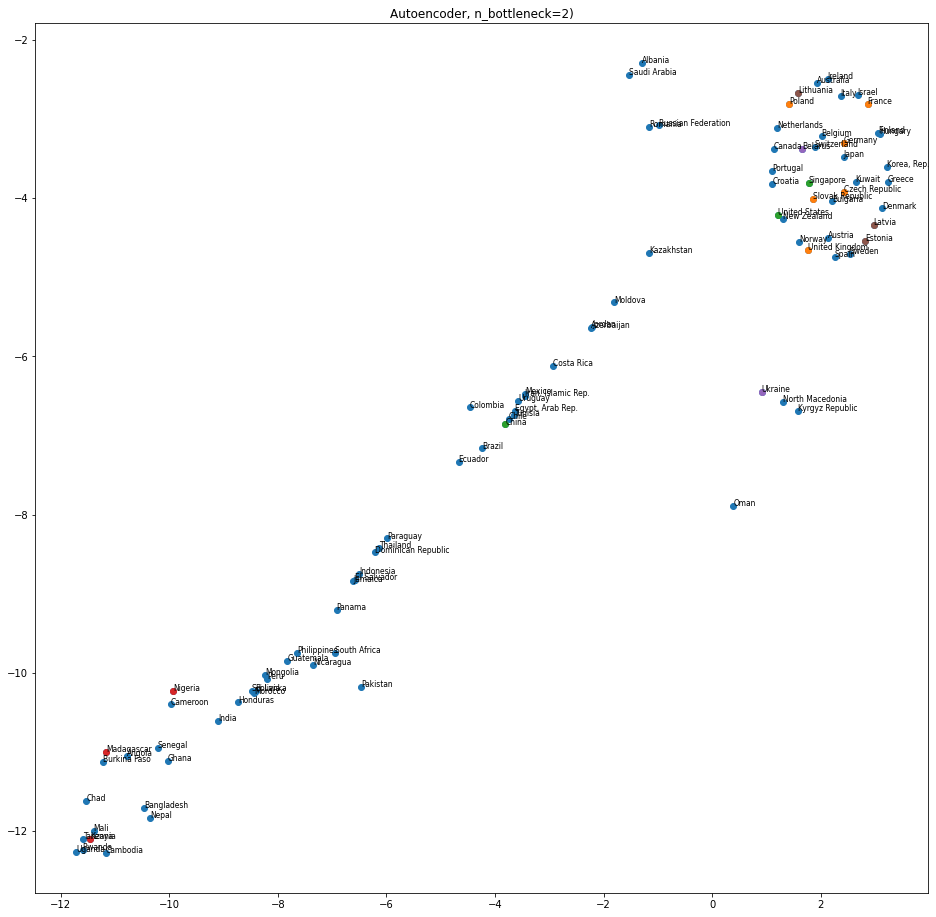

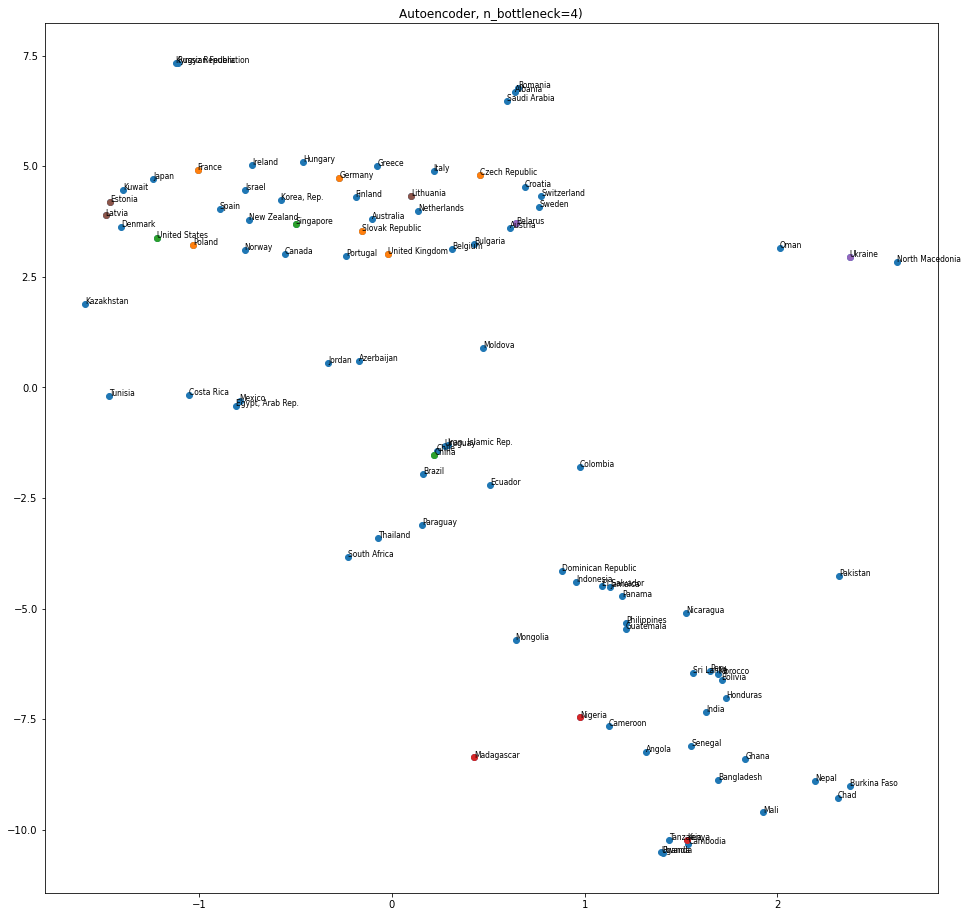

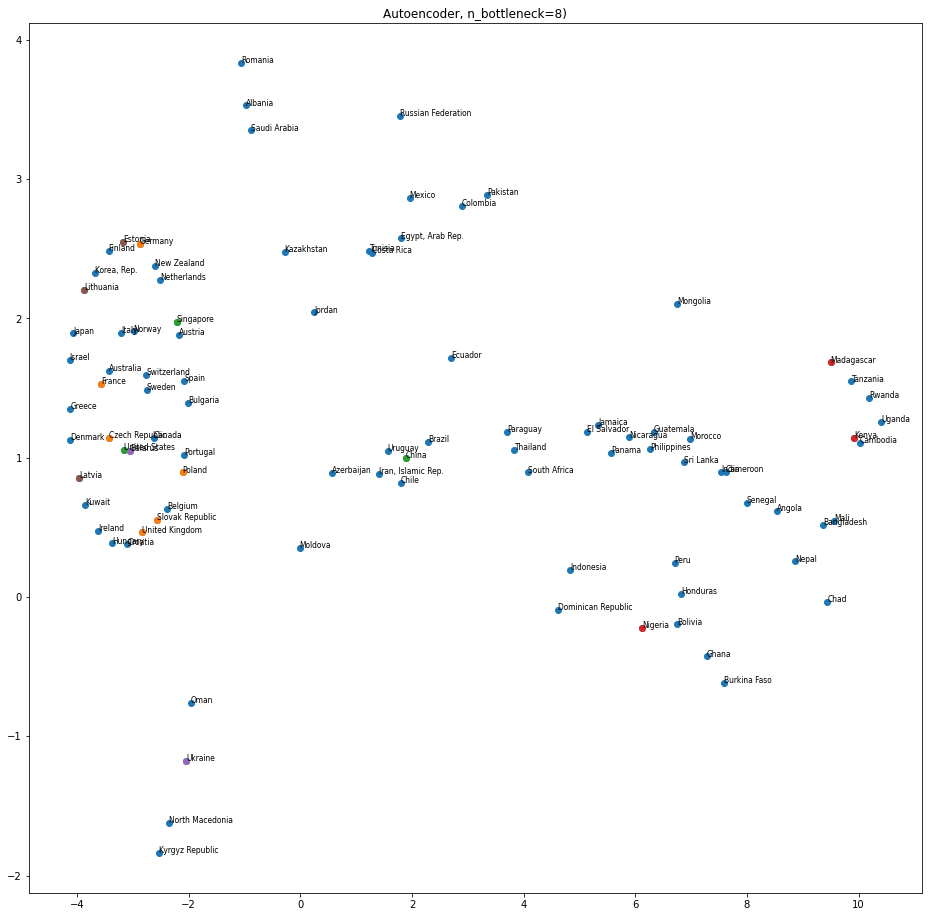

In [6]:
for extractor in EXTRACTORS:
    Y = time_series_dict[FEATURE]
    if extractor is not None:
        Y = extractor.extract_features(Y)

    Y_projected = ALG(**ALG_ARGS).fit_transform(Y)

    title = 'No extraction' if extractor is None else f'Autoencoder, n_bottleneck={extractor.autoencoder.n_bottleneck})'
    plot_with_names(Y_projected, countries, title=title)

# All time series types

In [7]:
INPUT_LEN = 21

algorithm = 'umap'

if algorithm == 'tsne':
    ALG = TSNE
    ALG_ARGS = {'n_components': 2, 'perplexity': 6, 'n_iter': 4000}
elif algorithm == 'mds':
    ALG = MDS
    ALG_ARGS = {'n_components': 2}
elif algorithm == 'isomap':
    ALG = Isomap
    ALG_ARGS = {'n_components': 2}
elif algorithm == 'lle':
    ALG = LocallyLinearEmbedding
    ALG_ARGS = {'n_components': 2}
elif algorithm == 'spectral':
    ALG = SpectralEmbedding
    ALG_ARGS = {'n_components': 2}
elif algorithm == 'umap':
    ALG = UMAP
    ALG_ARGS = {'n_components': 2, 'n_neighbors': 4, 'min_dist': 0.25}
else:
    raise ValueError()
    
print(algorithm)

EXTRACTORS = [
    None,
    AutoencoderExtractor(n_bottleneck=2, feature=FEATURE, root=pwd, input_len=INPUT_LEN),
    AutoencoderExtractor(n_bottleneck=4, feature=FEATURE, root=pwd, input_len=INPUT_LEN),
    AutoencoderExtractor(n_bottleneck=8, feature=FEATURE, root=pwd, input_len=INPUT_LEN)
]

umap


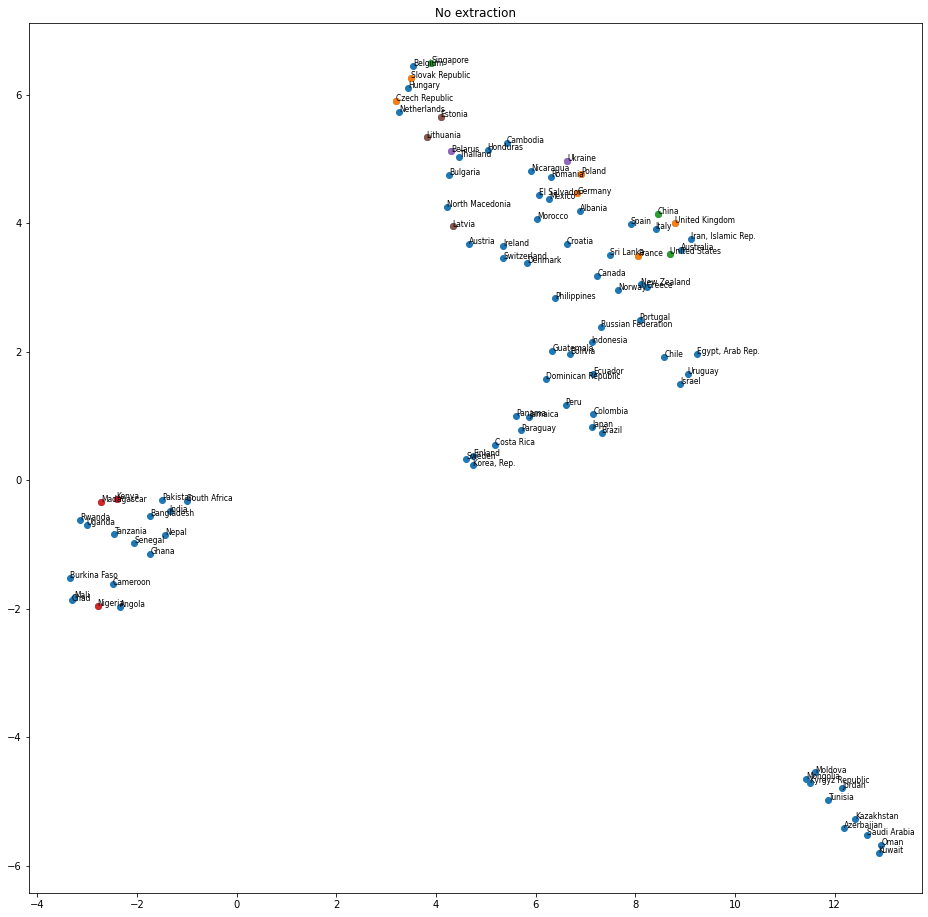

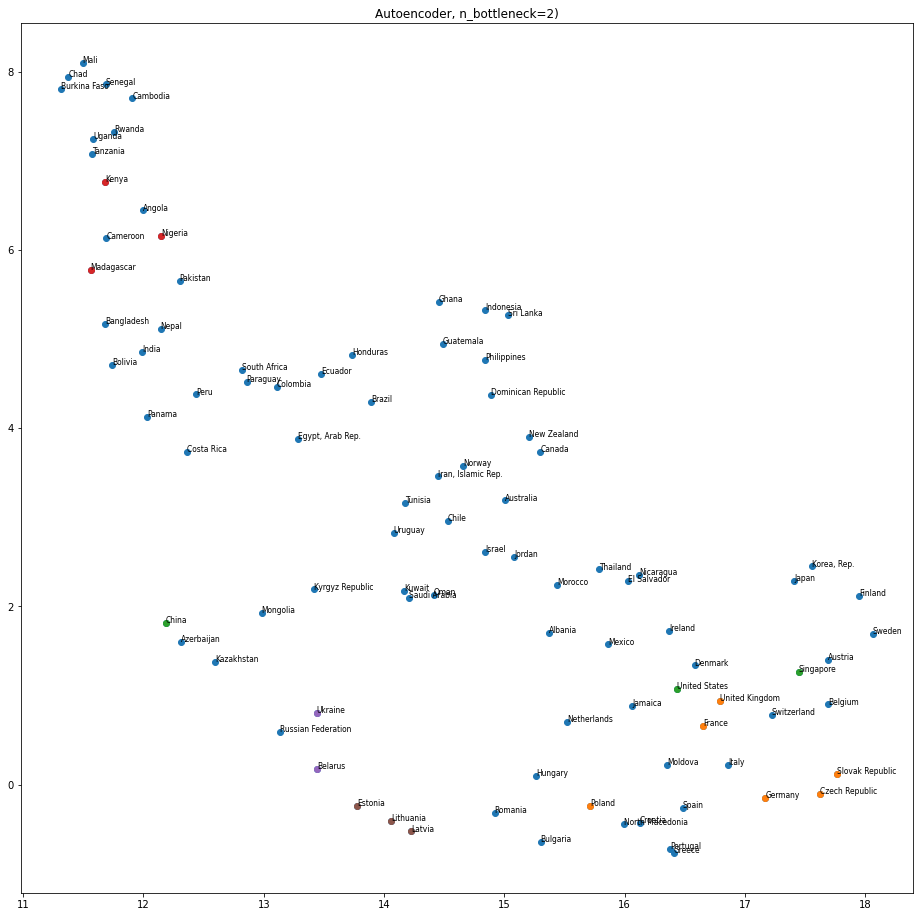

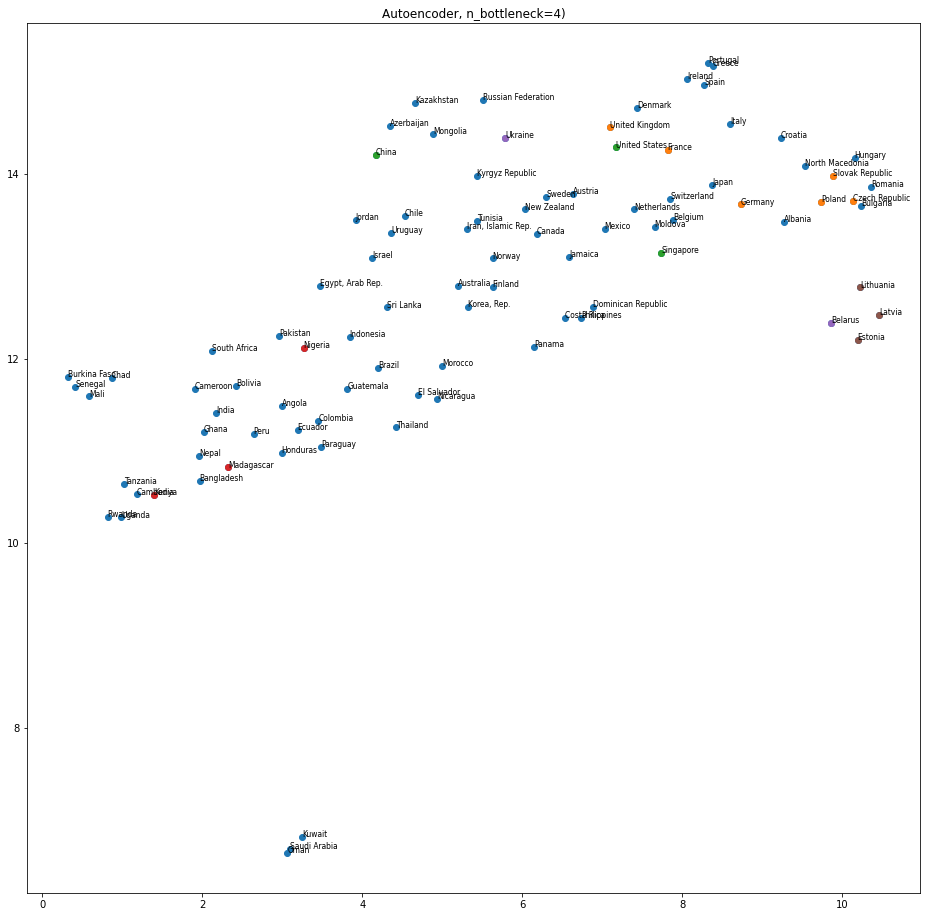

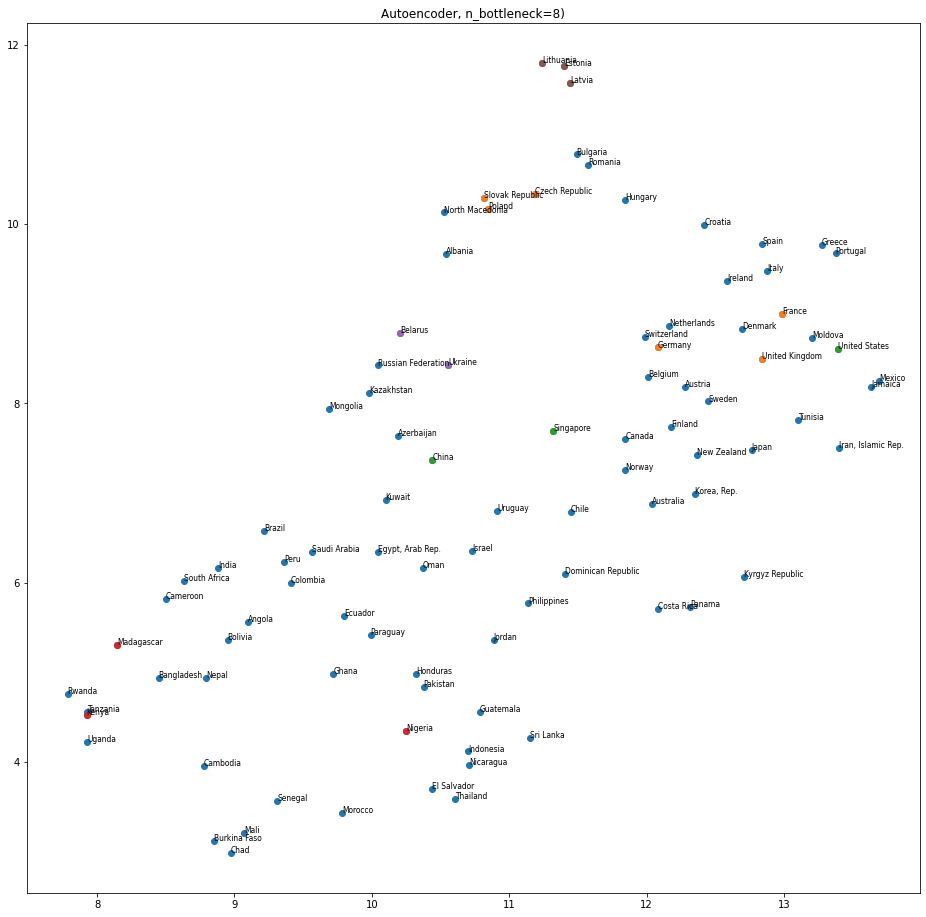

In [8]:
for extractor in EXTRACTORS:
    Y = extract_from_all(extractor)

    Y_projected = ALG(**ALG_ARGS).fit_transform(Y)

    title = 'No extraction' if extractor is None else f'Autoencoder, n_bottleneck={extractor.autoencoder.n_bottleneck})'
    plot_with_names(Y_projected, countries, title=title)